# Processing 30 kHz neural data
This notebook gives an overview of how we currently process 30 kHz raw neural data into spikes and spike-band power.

Before running this notebook:   
1. Download an example file containing raw neural recordings
```bash
mkdir -p ../data
cd ../data
wget https://gin.g-node.org/NIN/V1_V4_1024_electrode_resting_state_data/raw/bcf0f801f14e409ee12133aa305293cd32b1707f/data/L_SNR_250717/raw/NSP1_aligned.ns6
```
2. Calculate rereferencing parameters and thresholds for this data
```bash
python calc_params.py -f ../data/NSP1_aligned.ns6 -o ../data/NSP1_aligned_params.json -t -3.5 --reref lrr --plot_spike_panel
```
Once those steps are done, you can proceed.

In [1]:
import json

import brpylib
import matplotlib.pyplot as plt
import numpy as np
from utils import build_filter, plot_txpanel, rereference_data

DATA_PATH = '../data/NSP1_aligned.ns6'
PARAMS_PATH = '../data/NSP1_aligned_params.json'
MAX_SAMPLES = 10_000  # number of milliseconds to process

In [2]:
# Load NSX file and parameters
nsx_file = brpylib.NsxFile(DATA_PATH)
cont_data = nsx_file.getdata()

file_params = json.load(open(PARAMS_PATH))

In [3]:
# Initialize filter
n_channels = cont_data['data'][0].shape[0]
acausal_filter_lag = 120
filter_func, sos, zi, rev_win, rev_zi = build_filter(n_channels=n_channels,
                                                     but_low=250,
                                                     but_high=5000,
                                                     causal=False,
                                                     acausal_filter_type='fir',
                                                     acausal_filter_lag=120)

Loading 4 order, [250, 5000] hz bandpass acausal IIR-FIR filter


In [4]:
# Load thresholds and rereferencing weights
reref_params = np.array(file_params['rereference_parameters'])
thresholds = np.array(file_params['thresholds']).reshape(-1, 1)
reref_groups = np.array(file_params['reref_groups'])

In [5]:
# Process data
# sampling rate
sample_rate = (nsx_file.basic_header['SampleResolution'] /
               nsx_file.basic_header['Period'])
# samples per millisecond
samples_per_ms = int(sample_rate / 1000)
# milliseconds per recording
ms_per_record = cont_data['data'][0].shape[1] // samples_per_ms
# cap the data at MAX_SAMPLES
if MAX_SAMPLES is not None:
    ms_per_record = min(ms_per_record, MAX_SAMPLES)
# initialize output data
spikes = np.zeros((n_channels, ms_per_record), dtype=np.int16)
spike_band_power = np.zeros((n_channels, ms_per_record), dtype=np.float32)
filtered_data = np.zeros((n_channels, ms_per_record * samples_per_ms),
                         dtype=np.float32)
rereferenced_data = np.zeros((n_channels, ms_per_record * samples_per_ms),
                             dtype=np.float32)
# initialize buffers
rev_buffer = np.zeros(
    (n_channels, acausal_filter_lag + 30), dtype=np.float32) * np.nan
filt_buffer = np.zeros((n_channels, samples_per_ms), dtype=np.float32)
# process data for each millisecond window
for i in range(ms_per_record):
    # set indices for this window
    slice_start = i * samples_per_ms
    slice_end = slice_start + samples_per_ms
    # get raw data
    raw_data = cont_data['data'][0][:, slice_start:slice_end]
    # re-reference data
    reref_data = rereference_data(raw_data, reref_params)
    rereferenced_data[:, slice_start:slice_end] = reref_data
    # filter data
    filter_func(reref_data, filt_buffer, rev_buffer, sos, zi, rev_win, rev_zi)
    filtered_data[:, slice_start:slice_end] = filt_buffer.copy()
    # get spikes
    crossings = ((filt_buffer[:, 1:] < thresholds) &
                 (filt_buffer[:, :-1] >= thresholds))
    spikes[:, i] = np.any(crossings, axis=1).astype(np.int16)
    # get spike-band power
    spike_band_power[:, i] = 10 * np.log10(np.square(filt_buffer)).mean(axis=1)

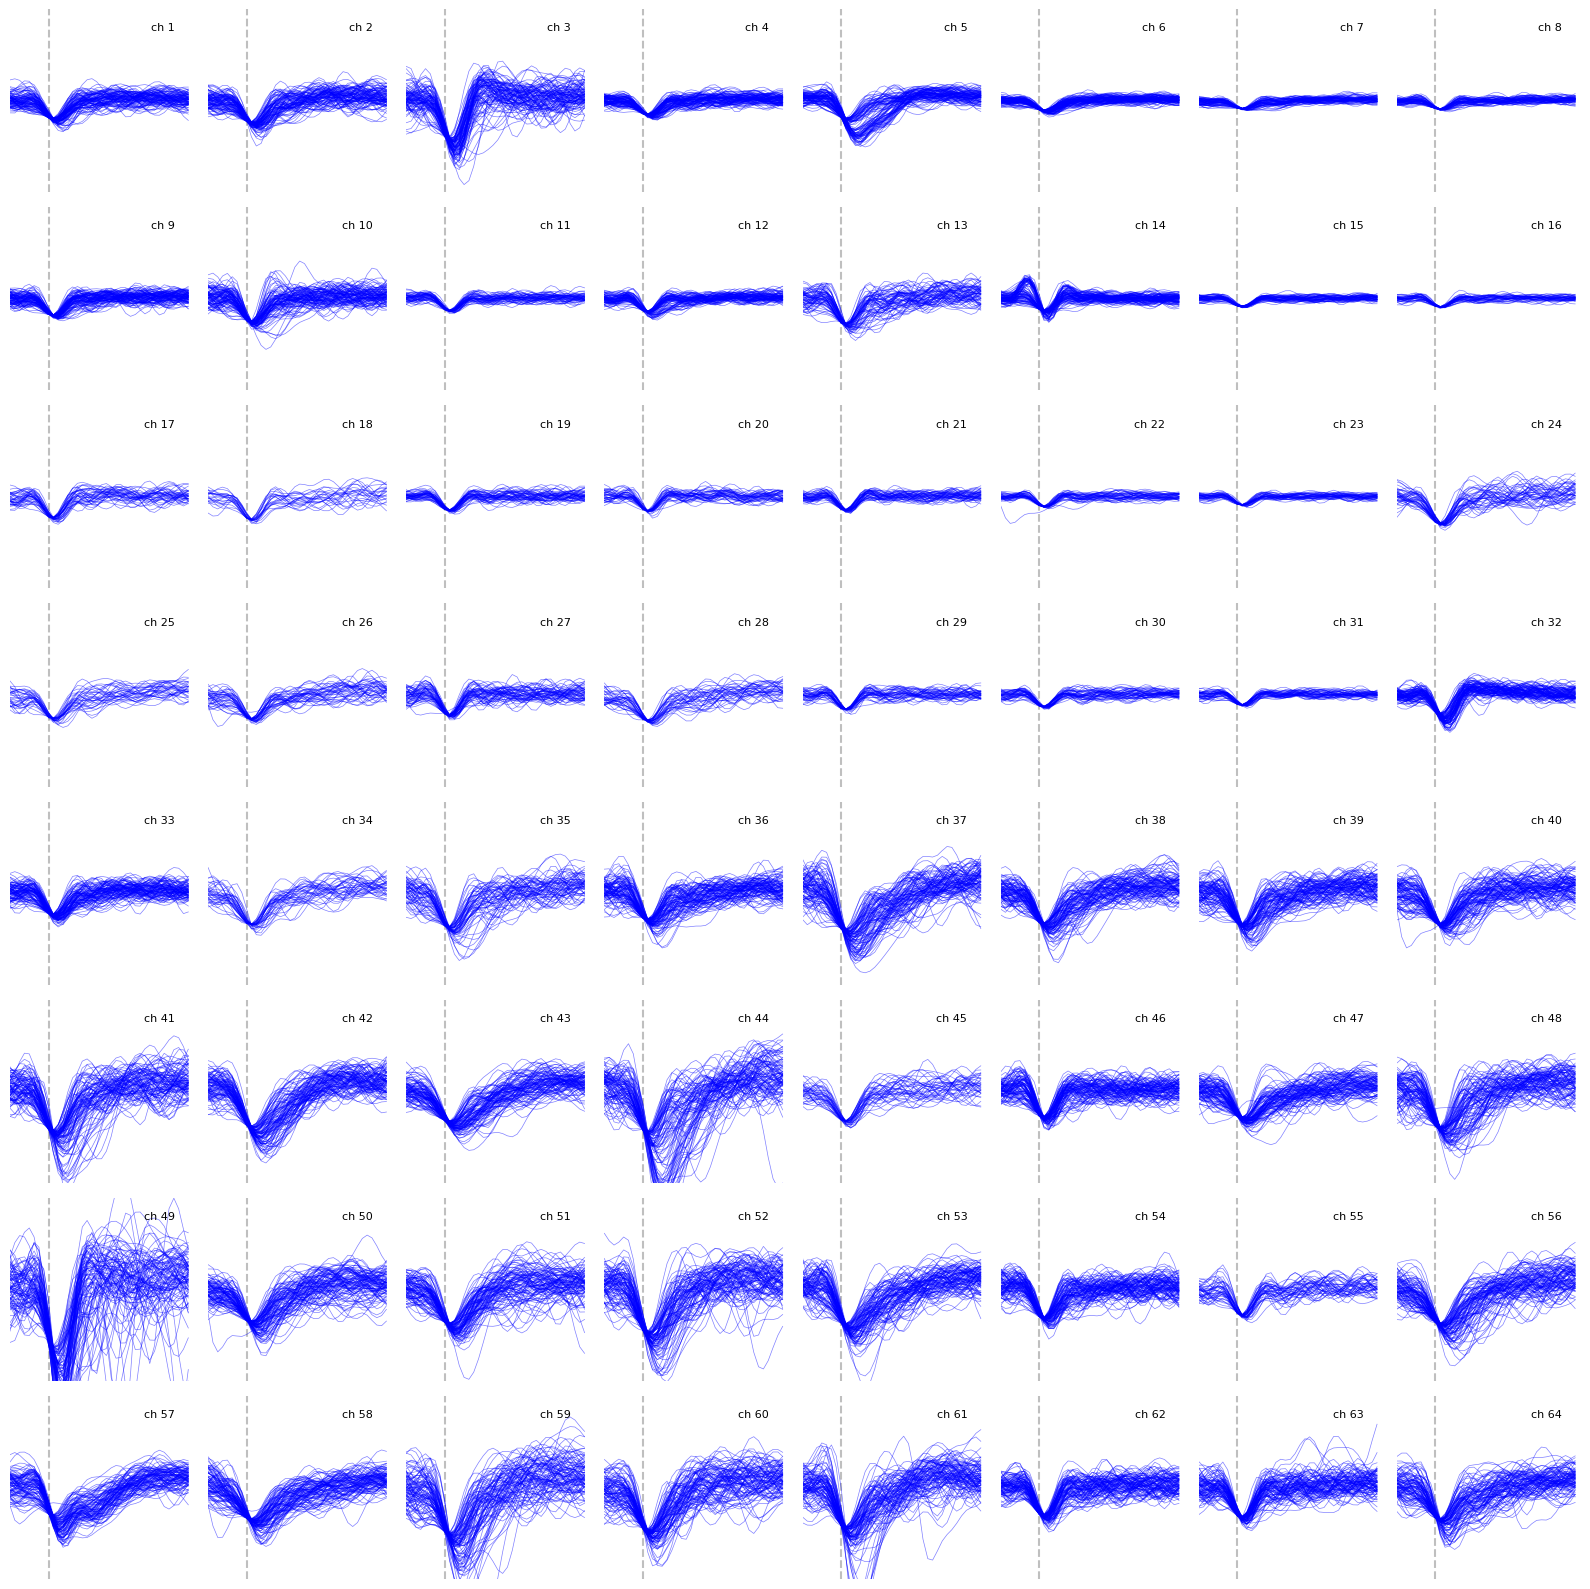

In [6]:
# Plot spike panels
mask = ~np.any(np.isnan(filtered_data), axis=0)  # exclude NaNs
plot_txpanel(filtered_data[:, mask],
             channels=reref_groups[0],
             thresholds=thresholds,
             max_samples=300_000)
plt.show()

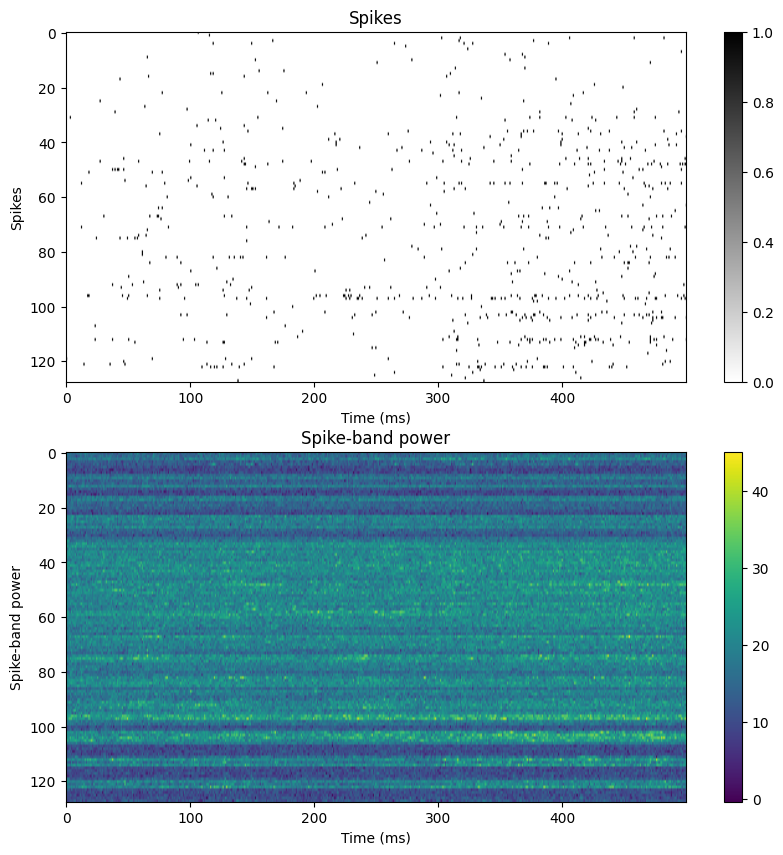

In [7]:
# Plot features
start_time = 0.1
end_time = 0.6
start_time_samples = int(start_time * sample_rate)
end_time_samples = int(end_time * sample_rate)
start_time_idx = start_time_samples // samples_per_ms
end_time_idx = end_time_samples // samples_per_ms

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# spikes
ax = axes[0]
im = ax.imshow(spikes[:, start_time_idx:end_time_idx],
               aspect='auto',
               cmap='binary')
ax.set_title('Spikes')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spikes')
plt.colorbar(im, ax=ax)
# spike-band power
ax = axes[1]
im = ax.imshow(spike_band_power[:, start_time_idx:end_time_idx], aspect='auto')
ax.set_title('Spike-band power')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spike-band power')
plt.colorbar(im, ax=ax)
plt.show()